In [1]:
# import python packages
import pandas as pd
import numpy as np

# import src code
import ase_evaluation as ae
#import benchmark_posteriors as bp
import bootstrap as btstrp
import cross_validation as cv
import logistic_regression as lr
import naive_bayes as nb
import network as ntwk
import process as prcs
#import RIVER as rvr
import simulate_data as sim
from scipy import interp

import matplotlib.pyplot as plt
import seaborn as sns
import benchmark_posteriors as bnchmk
import sklearn
import RIVER as river

In [9]:
s = sim.SimulateData("./test_output/", 'without_transfer', 0.4, 0.6, 0.01)
s._run()

# create a process object
p = prcs.Process('./test_output', 0.1)
p._process_simulated_data()

In [19]:
for col in p.z_labels.columns:
    print(np.count_nonzero(p.z_labels[col]) / len(p.z_labels[col]))

0.0656
0.0222
0.0067
0.6023
0.3701
0.0


In [33]:
c = 0
while True:
    isValid = True
    
    s = sim.SimulateData("./test_output/", 'without_transfer', 0.4, 0.6, 0.01)
    s._run()

    # create a process object
    p = prcs.Process('./test_output', 0.1)
    p._process_simulated_data()
    x = []
    for col in p.z_labels.columns: 
        x.append(np.count_nonzero(p.z_labels[col]) / len(p.z_labels[col]))
    for num in x:
        if num <= 0.01 or num >= 0.99:
            isValid = False
            break
    if isValid:
        break
    print(c)
    c+=1
print(x)

0
1
2
[0.9892, 0.7362, 0.9293, 0.2819, 0.2327, 0.0323]


In [8]:
p.train_list[0].columns

Index([                            0,                             1,
                                   2,                             3,
                                   4,                             5,
                                   6,                             7,
                                   8,                             9,
                                  10,                            11,
                                  12,                            13,
                                  14,                            15,
                                  16,                            17,
                                  18,                            19,
                                  20,                  'expr_label',
                 'median_expr_label',                     'z_label',
                    'median_z_label',                       'SPEER',
            'SPEER without transfer',                       'RIVER',
         'shared tissue genome onl

In [ ]:
s.z.head()

In [ ]:
for i in range(10):  
    s = sim.SimulateData("./test_output/", 'without_transfer', 0.4, 0.6, 0.01)
    s._run()
    x = []
    isGood = True
    for col in s.z.columns:
        x.append(np.count_nonzero(s.z[col]) / len(s.z[col]))
    for num in x:
        if num <= 0.01 or num >= 0.99:
            isGood = False
            break
    if isGood:
        print("winner")
        print(x)
        break

In [3]:
for i in range(10):
    s = sim.SimulateData("./test_output/", 'without_transfer', 0.4, 0.6, 0.01)
    s._run()
    x = []
    for col in s.z.columns:
        x.append(np.count_nonzero(s.z[col]) / len(s.z[col]))
    print(x)

[0.8278, 0.0324, 0.0002, 0.9972, 0.0141]
[1.0, 0.1603, 0.9925, 0.8202, 0.1967]
[0.9995, 0.9795, 0.0487, 0.7086, 0.9995]
[0.9546, 0.2636, 0.9105, 0.6512, 0.9193]
[0.2875, 0.791, 0.5267, 0.9584, 0.8315]
[0.9931, 0.2462, 0.5172, 0.4432, 0.1244]
[0.0127, 0.8781, 0.8281, 0.4898, 0.9927]
[0.3309, 0.7583, 0.9418, 0.804, 0.7915]
[0.1679, 0.2323, 0.2399, 0.7481, 0.2418]
[0.3891, 0.1196, 0.9355, 0.3203, 0.0908]


In [ ]:
test_data = []
models = ['SPEER', 'SPEER without transfer', 'RIVER', 'tissue specific genome only', 'shared tissue genome only']
fpr, tpr, auc, mean_tpr, mean_fpr, mean_auc = {}, {}, {}, {}, {}, {}
num_sims = 1
for model in models:
    mean_tpr[model] = {}
    mean_fpr[model] = {}
    mean_auc[model] = {}
for i in range(num_sims):
    # generate simulated data
    
    s = sim.SimulateData("./test_output/", 'with_transfer', 0.4, 0.6, 0.01)
    s._run()
    
    # create a process object
    p = prcs.Process('./test_output', 0.1)
    p._process_simulated_data()
    # run SPEER
    n = ntwk.Network(p.train_list, p.test_list, p.tissues, p.genomic_features, 
                 with_transfer=True, output_dir="SPEER_output", 
                 lambda_hp_parent = None,
                 lambda_hp_children_dict = None,
                 e_distribution = 'cat')
    train_list, test_list, beta_parent, beta_children, phi = n.run()
    
    # run SPEER without transfer
    lambda_hp_children_dict = {'brain': 0.01, 'group1': 0.01, 'muscle': 0.01, 'epithelial': 0.01, 'digestive': 0.01}
    n = ntwk.Network(train_list, test_list, p.tissues, p.genomic_features, 
                     with_transfer=False, output_dir="SPEER_output", 
                     lambda_hp_parent = None, 
                     lambda_hp_children_dict = lambda_hp_children_dict, 
                     e_distribution = 'cat')
    train_list, test_list, beta_parent, beta_children, phi = n.run()
    
    n = river.River(train_list, test_list, p.genomic_features, output_dir='RIVER_output')
    train_list, test_list, beta_parent_river, beta_children_river, phi_river = n.run()
    
    # add benchmarks 
    bn = bnchmk.BenchmarkPosteriors(train_list, test_list, p.genomic_features)
    train_list, test_list = bn.fit_models() 
    
    for model in models:
        auc = 0
        fpr_local, tpr_local, auc_local = {}, {}, {}
        # for each tissue
        for j in range(len(test_list)):
            fpr_local[j], tpr_local[j], _ = sklearn.metrics.roc_curve(test_list[j]["z_label"], test_list[j][model])
            auc_local[j] = sklearn.metrics.roc_auc_score(test_list[j]["z_label"], test_list[j][model])
        mean_tpr[model][i] = 0.0
        mean_fpr[model][i] = np.linspace(0,1,100)
        for j in range(len(test_list)):
            mean_tpr[model][i] += interp(mean_fpr[model][i], fpr_local[j], tpr_local[j])
            mean_tpr[model][i][0] = 0.0
        mean_tpr[model][i] /= len(test_list)
        mean_tpr[model][i][-1] = 1.0
        mean_auc[model][i] = sklearn.metrics.auc(mean_fpr[model][i], mean_tpr[model][i])
    print(i)

In [ ]:
import pickle
with open('mean_tpr.obj', 'wb') as fp:
    pickle.dump(mean_tpr, fp)
with open('mean_fpr.obj', 'wb') as fp:
    pickle.dump(mean_fpr, fp)
with open('mean_auc.obj', 'wb') as fp:
    pickle.dump(mean_auc, fp)

In [26]:
model_type = 'independent_weaker'

In [27]:
import pickle
with open('mean_tpr_' + model_type + '.obj', 'rb') as fp:
    mtpr = pickle.load(fp)
with open('mean_fpr_' + model_type + '.obj', 'rb') as fp:
    mfpr = pickle.load(fp)
with open('mean_auc_' + model_type + '.obj', 'rb') as fp:
    mauc = pickle.load(fp)

In [28]:
current_palette = sns.color_palette()
len(current_palette)

6

In [29]:
mean_tpr = mtpr
mean_fpr = mfpr
mean_auc = mauc
models = ['SPEER', 'SPEER without transfer', 'tissue specific genome only', 'shared tissue genome only']
num_sims = 75

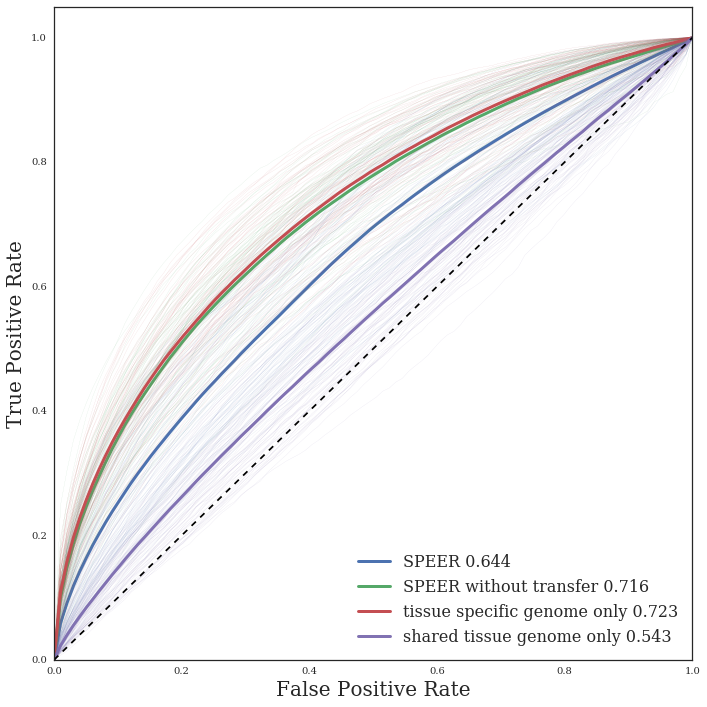

In [30]:
%matplotlib inline
fig = plt.figure(figsize=(10,10))
colors = ['blue', 'yellow', 'green', 'red', 'purple']
for ind,model in enumerate(models):
    mean_tpr_global = 0.0
    mean_fpr_global = np.linspace(0,1,100)
    for i in range(num_sims):
        fpr = mean_fpr[model][i]
        tpr = mean_tpr[model][i]
        ax = plt.plot(fpr, tpr, linewidth=0.05, c=current_palette[ind])

        
        mean_tpr_global += interp(mean_fpr_global, fpr, tpr)
        mean_tpr_global[0] = 0.0
        
    mean_tpr_global /= num_sims
    mean_tpr_global[-1] = 1.0
    auc_global = sklearn.metrics.auc(mean_fpr_global, mean_tpr_global)
    ax = plt.plot(mean_fpr_global, mean_tpr_global, label=model + ' {0:0.3f}'
              ''.format(auc_global), linewidth=3.0, c=current_palette[ind])

ax = plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
sns.set_context("talk")
sns.set_palette("deep")
sns.set(font='serif')
sns.set_style("white", {"font.family": "serif", "font.serif": ["Times", "Palatino", "serif"]})
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
plt.ylabel('True Positive Rate', fontsize=20)
#plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", frameon=False, prop={'size':16})
plt.tight_layout()
plt.savefig('../' + model_type + '_effects_roc.png', format='png', dpi=200)